In [14]:
import numpy as np
import cv2
from cv2 import Mat
import random
from IPython.display import Image, display

In [59]:
class TransferedPicture: #画像の相似変換
    def __init__(self,pic:Mat,scale,theta):
        self.orig_img=cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        h,w=self.orig_img.shape
        mat = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale) #相似変換のパラメータ設定
        self.img = cv2.warpAffine(self.orig_img, mat, (w, h)) #相似変換を実行
        self.scale=scale
        self.theta=theta
    
    def write(self,img_name):
        cv2.imwrite(img_name,self.img)
        
    def get_img_array(self): #オリジナル画像と変換後画像の配列を得る
        return self.orig_img, self.img

    def get_deff_array(self,img,axis=0): #微分画像を得る
        #axis=0: x方向の微分, axis=1: y方向の微分
        h,w=img.shape
        mat=np.zeros([h,w])
        for i in range(1,h-1):
            for j in range(1,w-1):
                if axis==0:
                    mat[i][j]=int((img[i][j+1]-img[i][j-1])/2)
                elif axis==1:
                    mat[i][j]=int((img[i+1][j]-img[i-1][j])/2)
        return mat

    def smooth_def(self): #x方向,y方向それぞれの平滑微分画像を生成
        gs=cv2.GaussianBlur(self.img,(3,3),3)
        #x方向の平滑微分画像
        dst_x=self.get_deff_array(gs,axis=0)
        #y方向の微分
        dst_y=self.get_deff_array(gs,axis=1)
        
        return dst_x,dst_y

In [131]:
class GaussNewton:
    def __init__(self,orig:np.array,st:np.array,i_x:np.array,i_y:np.array):
        #θとsを初期化
        #self.theta=random.uniform(-180,180)*np.pi/180
        #self.scale=random.random()
        self.theta=60
        self.scale=0.3
        #各画像配列を保持
        self.orig=orig
        self.st=st
        self.i_x=i_x
        self.i_y=i_y
        self.h,self.w=orig.shape
        
    def dx_dtheta(self,x,y):
        return self.scale*(-2*x*np.sin(np.radians(self.theta))-(2*y*np.cos(np.radians(self.theta))))
    def dy_dtheta(self,x,y):
        return self.scale*(2*x*np.cos(np.radians(self.theta))-(2*y*np.sin(np.radians(self.theta))))
    def dx_dscale(self,x,y):
        return 2*x*np.cos(np.radians(self.theta))-(2*y*np.sin(np.radians(self.theta)))
    def dy_dscale(self,x,y):
        return 2*x*np.sin(np.radians(self.theta))+(2*y*np.cos(np.radians(self.theta)))
    
    #1周分の計算を行う
    def calc_param(self):
        h,w=int(self.h/2),int(self.w/2)
        j_t=j_tt=j_s=j_ss=j_ts=.0
        print("θ={0}, s={1}".format(self.theta,self.scale))
        for i in range(-1*h,h):
            for j in range(-1*w,w):
                #配列の座標を画像の中心を原点とした座標に変換
                x,y=j,-1*i #y軸の正の方向を向かせる
                x_d=int(self.scale*(np.cos(np.radians(self.theta))*x-(np.sin(np.radians(self.theta))*y)))
                y_d=int(self.scale*(np.sin(np.radians(self.theta))*x+(np.cos(np.radians(self.theta))*y)))
                
                """dxdt=self.dx_dtheta(x_d,y_d)
                dydt=self.dy_dtheta(x_d,y_d)
                dxds=self.dx_dscale(x_d,y_d)
                dyds=self.dy_dscale(x_d,y_d)"""
                
                #配列の座標値に逆変換
                x,y=x+w,-1*y+h
                x_d,y_d=x_d+w-1,-1*y_d+h-1
                if x_d>self.w:
                    print("error",y_d,x_d)

                dxdt=self.dx_dtheta(x_d,y_d)
                dydt=self.dy_dtheta(x_d,y_d)
                dxds=self.dx_dscale(x_d,y_d)
                dyds=self.dy_dscale(x_d,y_d)
                
                #各微分式の計算
                """I_dash=self.st[y_d][x_d]
                I=self.orig[y][x]
                I_dash_x=self.i_x[y_d][x_d]
                I_dash_y=self.i_y[y_d][x_d]"""
                I_dash=self.st[x_d][y_d]
                I=self.orig[x][y]
                I_dash_x=self.i_x[x_d][y_d]
                I_dash_y=self.i_y[x_d][y_d]

                j_t+=(I_dash-I)*(I_dash_x*dxdt+(I_dash_y*dydt))
                j_tt+=np.square(I_dash_x*dxdt+(I_dash_y*dydt))
                j_s+=(I_dash-I)*(I_dash_x*dxds+(I_dash_y*dyds))
                j_ss+=np.square(I_dash_x*dxds+(I_dash_y*dyds))
                j_ts+=(I_dash_x*dxdt+(I_dash_y*dydt))*(I_dash_x*dxds+(I_dash_y*dyds))
        
        print("j_t={0} j_tt={1} j_s={2} j_ss={3} j_ts={4}".format(j_t,j_tt,j_s,j_ss,j_ts))
        #delta_thetaとdelta_scaleの計算
        mt=np.array([[j_tt,j_ts],[j_ts,j_ss]])
        deltas=-1*np.linalg.pinv(mt).dot(np.array([j_t,j_s]).T)
        print("Δθ={0}, Δs={1}".format(deltas[0],deltas[1]))
        return deltas[0],deltas[1]
    
    def until_convergence(self):
        eps=1e-8
        old_dt=old_ds=1000
        i=1
        while(True):
            print("{0}周目".format(i))
            new_dt,new_ds=self.calc_param()
            self.theta+=new_dt
            self.scale+=new_ds
            if abs(new_dt-old_dt)<eps and abs(new_ds-old_ds)<eps:
                print("収束を確認")
                print("最終値: θ={0}, s={1}".format(self.theta,self.scale))
                break
            i+=1
            old_dt,old_ds=new_dt,new_ds
        pass

In [102]:
def imshow(img):
    #ndarray 配列から画像をNotebook上に表示
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [122]:
pic_name="pic1.png"
pic_st_name="pic2.png"
#thetaとscaleの初期値を適当に決める
s,t=0.6,20
orig_img=cv2.imread(pic_name)
tp=TransferedPicture(pic=orig_img,scale=s,theta=t)
tp.write(pic_st_name)

#画像データを得る
orig_img,st_img=tp.get_img_array()
orig_array,st_array=np.array(orig_img),np.array(st_img)

#Iの計算
i_x,i_y=tp.smooth_def()
i_x_array,i_y_array=np.array(i_x),np.array(i_y)

/tmp/ipykernel_41747/835562618.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
  mat[i][j]=int((img[i][j+1]-img[i][j-1])/2)
/tmp/ipykernel_41747/835562618.py:25: RuntimeWarning: overflow encountered in ubyte_scalars
  mat[i][j]=int((img[i+1][j]-img[i-1][j])/2)


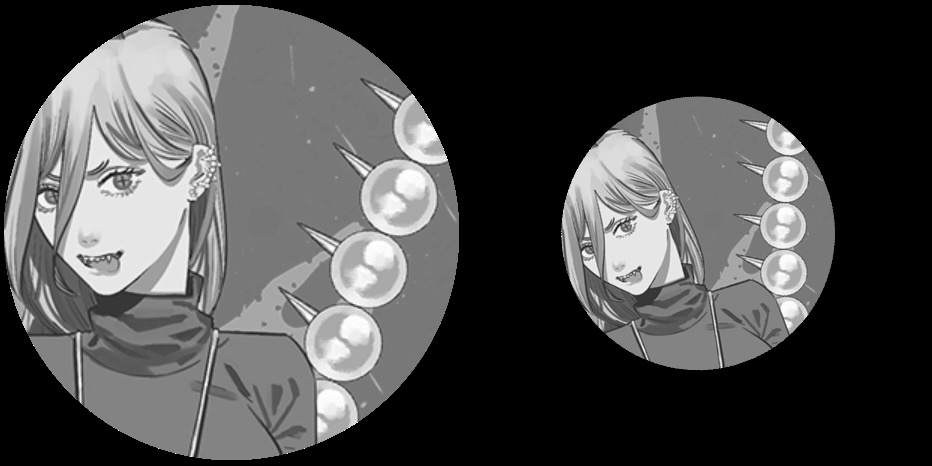

In [123]:
imgs=cv2.hconcat([orig_img,st_img])
imshow(imgs)

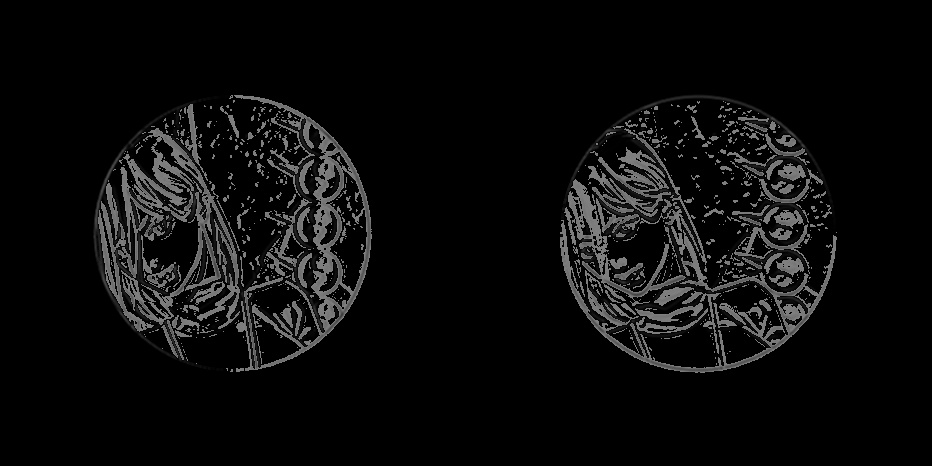

In [124]:
imgs=cv2.hconcat([i_x,i_y])
imshow(imgs)

In [125]:
orig_array[465][465],st_array[393][344]

(0, 0)

In [130]:
h,w=orig_array.shape
h,w=int(h/2),int(w/2)
scale,theta=0.6,20

j,i=-94,94
x,y=j,-1*i #y軸の正の方向を向かせる
x_d=int(scale*(np.cos(np.radians(theta))*x-(np.sin(np.radians(theta))*y)))
y_d=int(scale*(np.sin(np.radians(theta))*x+(np.cos(np.radians(theta))*y)))
x,y=x+w,-1*y+h
x_d,y_d=x_d+w-1,-1*y_d+h-1
I_dash=st_array[x_d][y_d]
I=orig_array[x][y]
I_dash_x=i_x_array[x_d][y_d]
I_dash_y=i_y_array[x_d][y_d]

j_t=(I_dash-I)*(I_dash_x*dxdt+(I_dash_y*dydt))
j_tt=np.square(I_dash_x*dxdt+(I_dash_y*dydt))
j_s=(I_dash-I)*(I_dash_x*dxds+(I_dash_y*dyds))
j_ss=np.square(I_dash_x*dxds+(I_dash_y*dyds))
j_ts=(I_dash_x*dxdt+(I_dash_y*dydt))*(I_dash_x*dxds+(I_dash_y*dyds))

#orig_array[x][y],st_array[x_d][y_d],orig_array[y][x],st_array[y_d][x_d]
I_dash,I,I_dash_x,I_dash_y

(120, 121, 126.0, 125.0)

In [132]:
gn=GaussNewton(orig=orig_array,st=st_array,i_x=i_x_array,i_y=i_y_array)
gn.until_convergence()

1周目
θ=60, s=0.3


/tmp/ipykernel_41747/3650522265.py:62: RuntimeWarning: overflow encountered in ubyte_scalars
  j_t+=(I_dash-I)*(I_dash_x*dxdt+(I_dash_y*dydt))
/tmp/ipykernel_41747/3650522265.py:64: RuntimeWarning: overflow encountered in ubyte_scalars
  j_s+=(I_dash-I)*(I_dash_x*dxds+(I_dash_y*dyds))


j_t=-248643096612.99002 j_tt=45146360844787.13 j_s=486691368719.4549 j_ss=324909525582294.8 j_ts=-54762565316564.07
Δθ=0.004638916663500576, Δs=-0.0007160528504649201
2周目
θ=60.0046389166635, s=0.29928394714953505
j_t=-248007045897.14392 j_tt=44918847173627.37 j_s=485516645213.93634 j_ss=324462747132823.3 j_ts=-54591288283595.414
Δθ=0.004654368413469513, Δs=-0.0007132673301364326
3周目
θ=60.00929328507697, s=0.2985706798193986
j_t=-247145418827.8138 j_tt=44634144951960.47 j_s=484874244850.2162 j_ss=324447478595815.2 j_ts=-54469792537738.266
Δθ=0.004670182256099656, Δs=-0.0007104089304209943
4周目
θ=60.01396346733307, s=0.2978602708889776
j_t=-246398906336.28748 j_tt=44387530821353.69 j_s=483230159931.5289 j_ss=323735088520024.06 j_ts=-54230130601396.91
Δθ=0.004686572151766338, Δs=-0.0007076055336343362
5周目
θ=60.01865003948484, s=0.29715266535534324
j_t=-245639196193.96268 j_tt=44138941573846.73 j_s=483059028571.76776 j_ss=323738862897245.9 j_ts=-54093168807557.21
Δθ=0.004698652449715459, Δs

KeyboardInterrupt: 